In [1]:
import numpy as np
import pandas as pd
import pymc3 as pm
import matplotlib.pyplot as plt
import arviz as az
import warnings
warnings.filterwarnings("ignore") # , category=FutureWarning
import scipy.stats as st
from collections import Counter

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
M = 150
J = 5
C = np.zeros((M, J))

# Parameter values
λ = 2.5                    # Expected abundance
p = 0.4                    # Probability of detection (per individual)

# Generate local abundance data (the truth)
N = st.poisson.rvs(λ, size = M)

# Conduct repeated measurements (generate replicated counts)
for i in range(J):
    C[:,i] = st.binom.rvs(n = N, p = p, size = M)


# Look at data
# The truth ....
table_truth = Counter(N)
print('True abundance distribution:', {k: v for k, v in sorted(table_truth.items(), key=lambda item: item[0])})
print('Total population size at M sites:', np.sum(N))
print('True number of occupied sites:', np.sum(N > 0))              
print('True mean abundance (estimate of λ):', np.mean(N))          
print()

# The observations...
table_obs = Counter(np.max(C, axis = 1))
print('Observed abundance distribution:', {int(k): v for k, v in sorted(table_obs.items(), key=lambda item: item[0])})
print('Observed total population size at M sites:', np.sum(np.max(C, axis = 1)))
print('Observed true number of occupied sites:', np.sum(np.max(C, axis = 1) > 0))              
print('Observed true mean abundance (estimate of λ):', np.mean(np.max(C, axis = 1)))          

True abundance distribution: {0: 12, 1: 25, 2: 40, 3: 38, 4: 20, 5: 12, 6: 3}
Total population size at M sites: 377
True number of occupied sites: 138
True mean abundance (estimate of λ): 2.513333333333333

Observed abundance distribution: {0: 15, 1: 49, 2: 48, 3: 32, 4: 5, 5: 1}
Observed total population size at M sites: 266.0
Observed true number of occupied sites: 135
Observed true mean abundance (estimate of λ): 1.7733333333333334


In [3]:
idx = np.repeat(np.arange(M), J)
C_t = C.flatten()
Nst = np.max(C, axis = 1) 

#### Model in BUGS language

```r
sink("model.txt")
cat("
model {
  # Priors
  lambda ~ dgamma(0.001, 0.001)
  p ~ dunif(0, 1)
  # Likelihood
  for (i in 1:M) {
    N[i] ~ dpois(lambda)      # State model
    for (j in 1:J) {
      C[i,j] ~ dbin(p, N[i]) # Observation model
    }
  }
}
",fill = TRUE)
sink()
```

In [4]:
with pm.Model() as model_6_3:
    
    λ = pm.Gamma('λ', 0.001, 0.001)
    p = pm.Uniform('p', 0, 1)
    N = pm.Poisson('N', λ, initval = Nst, shape = M)
    y_likelihood = pm.Binomial('y_likelihood', p = p, n = N[idx], observed = C_t)
    
    trace_6_3 = pm.sample(4000, tune = 2000, return_inferencedata = True)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [p, λ]
>Metropolis: [N]


Sampling 2 chains for 2_000 tune and 4_000 draw iterations (4_000 + 8_000 draws total) took 34 seconds.


In [5]:
az.summary(trace_6_3, var_names = ['~N'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
λ,1.772,0.112,1.563,1.977,0.001,0.001,7259.0,5609.0,1.0
p,0.556,0.014,0.530,0.582,0.000,0.000,7207.0,5492.0,1.0


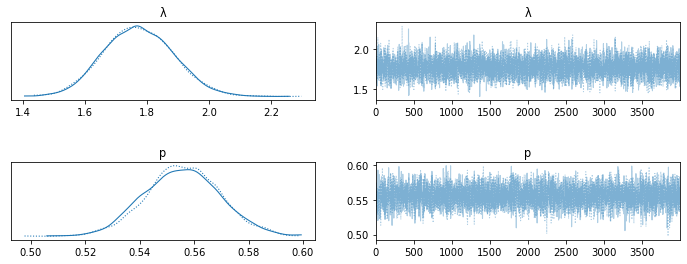

In [6]:
az.plot_trace(trace_6_3, var_names = ['~N'])
plt.subplots_adjust(hspace = 0.8, wspace=0.2);